<a href="https://colab.research.google.com/github/milkywayweaver/learn_pytorch/blob/main/projects/PyT_P002_Multiclass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MULTICLASS CLASSIFICATION USING PYTORCH** <br>
<br>
💡 This project aims to classify colors from its RGB values (converted from hexcodes). The data I use is a color dataset I made myself, consisting of hexcodes and its color labels. <br>
💾 Link to the dataset:
https://github.com/milkywayweaver/learn_pytorch/blob/main/projects/color_hexcodes_3.csv <br>
❗ The dataset only contains brighter colors. Predictions of darker colors may not be very good. <br>
❗ Do note that because how the data is made, there maybe some wrong labels for some hexcodes, therefore giving inacurate result in the model.<br>
<br>
📖 Link to the course I follow: <br>
* PyTorch for Deep Learning & Machine Learning - freeCodeCamp.org, taught by Daniel Bourke. <br>
https://youtu.be/V_xro1bcAuA?si=luBE0ln8qKDfQWyM

In [19]:
import torch
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
def hex_to_rgb(hexcode):
  r,g,b = [int(hexcode[i:i+2],16) for i in [0,2,4]]
  return r,g,b

def plot_loss_curve():
  fig,ax = plt.subplots(figsize=(4,4))
  ax1 = ax.twinx()
  ax.plot(epoch_counts,test_losses,label='Loss',color='C1')
  ax1.plot(epoch_counts,test_accs,label='Accuracy',color='C2')
  ax.set_xlabel('Epochs')
  ax1.set_xlabel('Epochs')
  ax.set_ylabel('Loss',color='C1')
  ax1.set_ylabel('Accuracy',color='C2')
  plt.title('Loss Curve')
  plt.show()

✅ Prepare the data

In [22]:
hexcodes = pd.read_csv('color_hexcodes_3.csv')
hexcodes['Hexcodes'] = hexcodes['Hexcodes'].str.lstrip('#')
hexcodes['R'] = hexcodes['Hexcodes'].apply(lambda x:int(x[0:2],16))
hexcodes['G'] = hexcodes['Hexcodes'].apply(lambda x:int(x[2:4],16))
hexcodes['B'] = hexcodes['Hexcodes'].apply(lambda x:int(x[4:6],16))

hexcodes.head(5)

,Hexcodes,Labels,R,G,B
0,fd070b,red,253,7,11
1,f9070b,red,249,7,11
2,f40408,red,244,4,8
3,f6161a,red,246,22,26
4,f52226,red,245,34,38


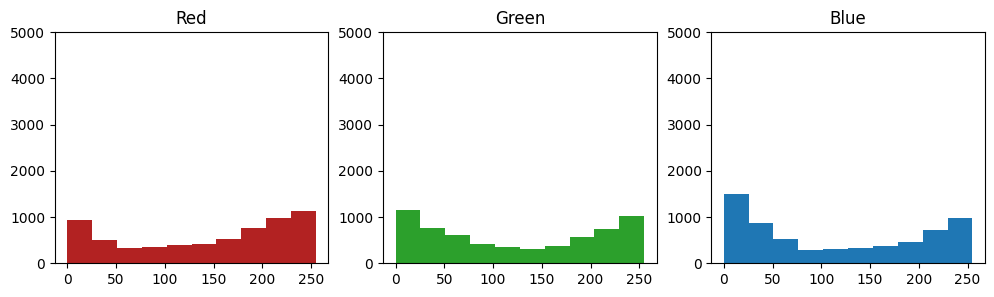

In [23]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
ax[0].hist(hexcodes['R'],color='firebrick')
ax[0].set_title('Red')
ax[0].set_ylim(0,5000)
ax[1].hist(hexcodes['G'],color='C2')
ax[1].set_title('Green')
ax[1].set_ylim(0,5000)
ax[2].hist(hexcodes['B'],color='C0')
ax[2].set_title('Blue')
ax[2].set_ylim(0,5000)
plt.show()

In [24]:
# Normalize data and set one hot encoding
X_pd = hexcodes[['R','G','B']]
y_pd = hexcodes[['Labels']]

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder

ct = make_column_transformer((MinMaxScaler(),['R','G','B']))
ct.fit(X_pd)
X_np = ct.transform(X_pd)

ct = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),['Labels']))
ct.fit(y_pd)
y_np = ct.transform(y_pd).toarray()

color_list = ct.transformers_[0][1].categories_[0]

✅ Load the data into tensors

In [25]:
# Load data into tensors
X = torch.tensor(X_np,device=device,dtype=torch.float32)
y = torch.tensor(y_np,device=device,dtype=torch.float32)

# Split the data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [26]:
X_train.shape,y_train.shape

(torch.Size([5068, 3]), torch.Size([5068, 11]))

In [27]:
y_train.argmax(1)

tensor([5, 7, 8,  ..., 7, 4, 0])

✅ Build the model

In [28]:
class MultiClassification(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_layer = nn.Linear(in_features=3,out_features=512,device=device)
    self.layer_1 = nn.Linear(in_features=512,out_features=512,device=device)
    self.output_layer = nn.Linear(in_features=512,out_features=len(color_list),device=device)
    self.relu = nn.ReLU()

  def forward(self,x: torch.Tensor):
    return self.output_layer(self.relu(self.layer_1(self.relu(self.input_layer(x)))))

✅ Build the training loop

In [29]:
def accuracy(y_preds,y_test):
  # Shape of y_preds is nx1, y_test is nxlabel
  acc = torch.eq(y_preds,y_test.argmax(1)).sum().item()
  return acc/len(y_preds)*100

def train(model,epochs,lr):
  epoch_counts = []
  test_losses = []
  test_accs = []

  # Setup loss function and optimizer
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)

  # Initiate training loop
  for epoch in range(epochs):
    # Train
    model.train()
    y_logits = model(X_train.type(torch.float32))
    y_preds = torch.softmax(y_logits,1).argmax(1)
    loss = loss_fn(y_logits,y_train.argmax(1))
    acc = accuracy(y_preds,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate
    model.eval()
    with torch.inference_mode():
      test_logits = model(X_test.type(torch.float32))
      test_preds = torch.softmax(test_logits,1).argmax(1)
      test_loss = loss_fn(test_logits,y_test.argmax(1))
      test_acc = accuracy(test_preds,y_test)

    if epoch % int(epochs/20) == 0:
      print(f'Epoch: {epoch}\t| Accuracy: {acc:.2f}\t|  Test Accuracy: {test_acc:.2f}')

    epoch_counts.append(epoch)
    test_losses.append(test_loss.detach().item())
    test_accs.append(test_acc)

  return epoch_counts,test_losses,test_accs

In [30]:
model_0 = MultiClassification()
epoch_counts,test_losses,test_accs = train(model_0,100,0.01)

Epoch: 0	| Accuracy: 0.04	|  Test Accuracy: 43.38
Epoch: 5	| Accuracy: 68.86	|  Test Accuracy: 72.08
Epoch: 10	| Accuracy: 90.37	|  Test Accuracy: 92.59
Epoch: 15	| Accuracy: 96.21	|  Test Accuracy: 96.29
Epoch: 20	| Accuracy: 96.90	|  Test Accuracy: 97.32
Epoch: 25	| Accuracy: 97.40	|  Test Accuracy: 98.19
Epoch: 30	| Accuracy: 97.85	|  Test Accuracy: 98.03
Epoch: 35	| Accuracy: 97.81	|  Test Accuracy: 98.26
Epoch: 40	| Accuracy: 97.59	|  Test Accuracy: 98.19
Epoch: 45	| Accuracy: 97.69	|  Test Accuracy: 98.03
Epoch: 50	| Accuracy: 97.63	|  Test Accuracy: 98.11
Epoch: 55	| Accuracy: 97.49	|  Test Accuracy: 98.19
Epoch: 60	| Accuracy: 97.61	|  Test Accuracy: 98.19
Epoch: 65	| Accuracy: 97.81	|  Test Accuracy: 98.03
Epoch: 70	| Accuracy: 97.42	|  Test Accuracy: 98.11
Epoch: 75	| Accuracy: 97.67	|  Test Accuracy: 98.03
Epoch: 80	| Accuracy: 97.75	|  Test Accuracy: 98.19
Epoch: 85	| Accuracy: 97.79	|  Test Accuracy: 98.19
Epoch: 90	| Accuracy: 97.73	|  Test Accuracy: 98.03
Epoch: 95	| Acc

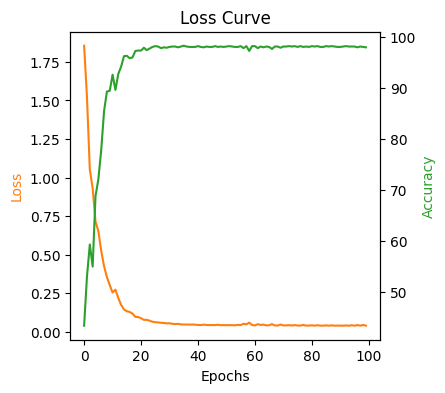

Test accuracy: 97.95%


In [31]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test)
  y_preds = torch.softmax(y_logits,1)
plot_loss_curve()


print(f'Test accuracy: {np.round(accuracy(y_preds.argmax(1),y_test),2)}%')

✅ Evaluate the model on a new random hexcode

blue
[ 67.  84. 209.]


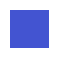

In [32]:
random_hex = [[np.random.randint(0,255) for i in range(3)]]
random_hex = ['{:02x}{:02x}{:02x}'.format(*rgb) for rgb in random_hex][0]
rgb = torch.tensor([int(random_hex[i:i+2],16) for i in [0,2,4]],device=device,dtype=torch.float32).unsqueeze(0)

model_0.eval()
with torch.inference_mode():
  y_pred = model_0(rgb).argmax(1)

color_index = y_pred
print(color_list[color_index])
print(rgb.numpy().ravel())
plt.figure(figsize=(0.5,0.5))
plt.axis('off')
plt.imshow([rgb.type(torch.int32)])
plt.show()